# Advances in Modern Financial Machine Learning
## Idea by Marcos Lopez de Prado

# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import copy
import scipy.stats as ss
import sklearn.metrics
import sklearn.ensemble
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime

from sklearn.tree import plot_tree

# 2. Data reading

In [2]:
df = pd.read_csv("SP.csv")

In [3]:
df1 = df[(df != 0).all(1)].reset_index()
df1 = df1[int(6.45e6):int(6.5e6)]
df1["date"] = pd.to_datetime(df1["date"])
df1.index = df1["date"]
df1 = df1.drop(['index', 'time', 'date'], axis=1)
df1.head()

,price,volume
date,,
2017-08-09,2466.3,1
2017-08-09,2466.3,1
2017-08-09,2466.1,1
2017-08-09,2466.1,1
2017-08-10,2467.2,1


# 3. Bars

## 3.1 Base Class for Bars

In [4]:
class Bars:
    
    def __init__(self, dataframe):
        
        self.df = dataframe
        
    def _create_basic_lists(self):
        
        dates_beg = []
        dates_end = []
        
        bars_open = []
        bars_close = []
        
        bars_high = []
        bars_low = []
        
        volumes = []
        
        return dates_beg, dates_end, bars_high, bars_low, bars_open, bars_close, volumes
    
    
    def _create_bar_df(self, dates_beg, dates_end, bars_high, bars_low, bars_open, bars_close, volumes):
        
        output_df = pd.DataFrame({'index' : dates_beg,
                                  'Date_start' : dates_beg,
                                'Date_end' : dates_end,
                                'High' : bars_high,
                                 'Low' : bars_low,
                                 'Open' : bars_open,
                                 'Close' : bars_close,
                                 'Volume' : volumes}, 
                                columns=['index', 'Date_start','Date_end', 'High', 'Low', 'Open', 'Close', 'Volume'])
        
        output_df.index = output_df["index"]
        return output_df
    
    
    def _ewma(self, data_point, data_prev, alpha):
        
        return alpha * data_point + (1 - alpha) * data_prev
        
    
    @staticmethod    
    def plot_bars(df, figsize = (5,2), font = 8, candle_width = 0.5):
        
        #create figure
        plt.figure(figsize = figsize)
        plt.rc('font', size = font)
        
        #define width of candlestick elements
        width = candle_width
        width2 = .05

        #define up and down prices
        up = df[df.Close>=df.Open]
        down = df[df.Close<df.Open]

        #define colors to use
        col1 = 'green'
        col2 = 'red'

        #plot up prices
        plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
        plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
        plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

        #plot down prices
        plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
        plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
        plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

        #rotate x-axis tick labels
        plt.xticks(rotation=45, ha='right')

        #display candlestick chart
        plt.show()
    
    
    def create_time_bars(self, time_horizon_days: int):
        
        df1 = self.df
        
        date_array = df1.index.drop_duplicates()
        
        date_start = date_array[0]
        date_last = date_array[-1]
        
        dates_beg, dates_end, bars_high, bars_low, bars_open, bars_close, volumes = self._create_basic_lists()
        
        dates_beg.append(date_start)
        
        for i in range(1, int(np.round((date_last - date_start).days / time_horizon_days, 0))):
            dates_beg.append(dates_beg[i-1] + datetime.timedelta(days = time_horizon_days))
            
        dates_end = dates_beg[1:]
        dates_end.append(date_last)
        
        for i in range(0, len(dates_beg)):
            sliced_df = df1.loc[dates_beg[i]:dates_end[i]]
            if len(sliced_df) != 0:
                bars_high.append(max(sliced_df['price']))
                bars_low.append(min(sliced_df['price']))
                bars_open.append(sliced_df['price'][0])
                bars_close.append(sliced_df['price'][-1])
                volumes.append(np.sum(sliced_df['volume']))
            
            else:
                bars_high.append(np.nan)
                bars_low.append(np.nan)
                bars_open.append(np.nan)
                bars_close.append(np.nan)
                volumes.append(np.nan)
        
        output = self._create_bar_df(dates_beg, dates_end, bars_high, bars_low, 
                                  bars_open, bars_close, volumes)
        
        return output
    
    
    def create_tick_bars(self, tick_treshold):
        
        df1 = self.df
        
        dates_beg, dates_end, bars_high, bars_low, bars_open, bars_close, volumes = self._create_basic_lists()
        
        for i in range(0, len(df1) + 1 - tick_treshold, tick_treshold):
            sliced_df = df1[i:i+tick_treshold]
            bars_high.append(max(sliced_df['price']))
            bars_low.append(min(sliced_df['price']))
            bars_open.append(sliced_df['price'][0])
            bars_close.append(sliced_df['price'][-1])
            volumes.append(np.sum(sliced_df['volume']))
            dates_beg.append(sliced_df.index[0])
            dates_end.append(sliced_df.index[-1])
        
        output = self._create_bar_df(dates_beg, dates_end, bars_high, bars_low, 
                                  bars_open, bars_close, volumes)
        
        return output
    
    
    def create_volume_bars(self, volume_treshold):
        
        df1 = self.df
        
        dates_beg, dates_end, bars_high, bars_low, bars_open, bars_close, volumes = self._create_basic_lists()
        
        start_i = 0
        end_i = 0
        
        while start_i < len(df1):
            vol_sum = 0
            while vol_sum <= volume_treshold and end_i < len(df1):
                vol_sum = vol_sum + df1['volume'][end_i]
                end_i = end_i + 1
            
            sliced_df = df1[start_i:end_i]
            bars_high.append(max(sliced_df['price']))
            bars_low.append(min(sliced_df['price']))
            bars_open.append(sliced_df['price'][0])
            bars_close.append(sliced_df['price'][-1])
            volumes.append(np.sum(sliced_df['volume']))
            dates_beg.append(sliced_df.index[0])
            dates_end.append(sliced_df.index[-1])
            
            start_i = end_i
            
        output = self._create_bar_df(dates_beg, dates_end, bars_high, bars_low, 
                                  bars_open, bars_close, volumes)
        
        return output
    
    
    def create_dollar_bars(self, dollar_treshold):
        
        df1 = self.df
        
        dates_beg, dates_end, bars_high, bars_low, bars_open, bars_close, volumes = self._create_basic_lists()
        
        start_i = 0
        end_i = 0
        
        while start_i < len(df1):
            dol_sum = 0
            while dol_sum <= dollar_treshold and end_i < len(df1):
                dol_sum = dol_sum + df1['volume'][end_i] * df1['price'][end_i]
                end_i = end_i + 1
            
            sliced_df = df1[start_i:end_i]
            bars_high.append(max(sliced_df['price']))
            bars_low.append(min(sliced_df['price']))
            bars_open.append(sliced_df['price'][0])
            bars_close.append(sliced_df['price'][-1])
            volumes.append(np.sum(sliced_df['volume']))
            dates_beg.append(sliced_df.index[0])
            dates_end.append(sliced_df.index[-1])
            
            start_i = end_i
            
        output = self._create_bar_df(dates_beg, dates_end, bars_high, bars_low, 
                                  bars_open, bars_close, volumes)
        
        return output
    
    
    def imbalance_bars(self, candle_length_init, expected_tick_init, type_bar, alpha = .005):
        
        df1 = self.df
        cum_theta = 0
        
        dates_beg, dates_end, bars_high, bars_low, bars_open, bars_close, volumes = self._create_basic_lists()
        ticks_len = []
        
        if type_bar == 'tick':
            imbalance = np.sign(df1['price'].diff()).dropna()
            for i in range(len(imbalance)):
                if imbalance[i] == 0:
                    imbalance[i] = imbalance[i-1]
        
        elif type_bar == 'volume':
            diff = np.sign(df1['price'].diff()).dropna()
            imbalance = np.sign(df1['price'].diff()).dropna()
            for i in range(len(diff)):
                if diff[i] == 0:
                    imbalance[i] = diff[i-1] * df1['volume'][i + 1]
                else:
                    imbalance[i] = diff[i] * df1['volume'][i + 1]
                    
        elif type_bar == 'dollar':
            imbalance = np.sign(df1['price'].diff()).dropna()
            diff = np.sign(df1['price'].diff()).dropna()
            for i in range(len(diff)):
                if diff[i] == 0:
                    imbalance[i] = diff[i-1] * df1['volume'][i + 1] * df1['price'][i + 1]
                else:
                    imbalance[i] = diff[i] * df1['volume'][i + 1] * df1['price'][i + 1]
                    
        else:
            raise TypeError('Choose from: "tick", "volume", "dollar"')
        
        expected_length = candle_length_init
        emwa_imbalance = expected_tick_init
        expected_imbalance = emwa_imbalance * expected_length
        
        start_i = 0
        end_i = 0
        
        thetas = []
        thresholds = []
        
        for i in range(len(df1)-1):
            
            cum_theta = cum_theta + imbalance[i]
            
            emwa_imbalance = self._ewma(imbalance[i], emwa_imbalance, alpha)
            
            end_i = i
            
            if abs(cum_theta) >= expected_imbalance:
                
                
                tick_length = end_i - start_i
                
                sliced_df = df1[start_i:end_i]
                
                bars_high.append(max(sliced_df['price']))
                bars_low.append(min(sliced_df['price']))
                bars_open.append(sliced_df['price'][0])
                bars_close.append(sliced_df['price'][-1])
                volumes.append(np.sum(sliced_df['volume']))
                dates_beg.append(sliced_df.index[0])
                dates_end.append(sliced_df.index[-1])
                ticks_len.append(tick_length)
                
                expected_length = self._ewma(tick_length, expected_length, alpha)
                expected_imbalance = abs(emwa_imbalance) * expected_length
                
                cum_theta = 0
                start_i = end_i
                
            thetas.append(cum_theta)
            thresholds.append(expected_imbalance)
        
        
        output = self._create_bar_df(dates_beg, dates_end, bars_high, bars_low, 
                                  bars_open, bars_close, volumes)
                
        return output, thetas, thresholds


In [5]:
SP500 = Bars(df1)

## 3.2 Time Bars

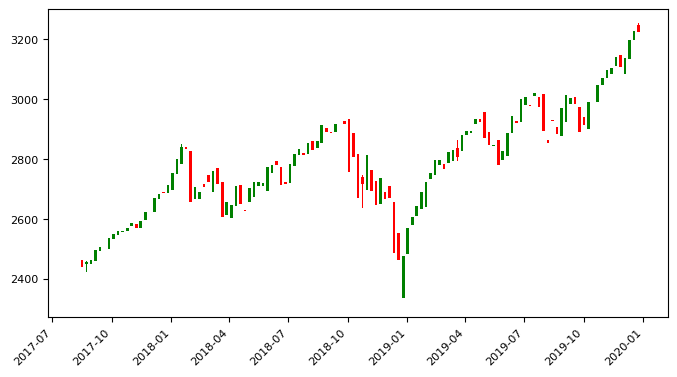

In [6]:
time_bars = SP500.create_time_bars(7)
SP500.plot_bars(time_bars, figsize = (8, 4), candle_width = 4)

## 3.3 Tick Bars

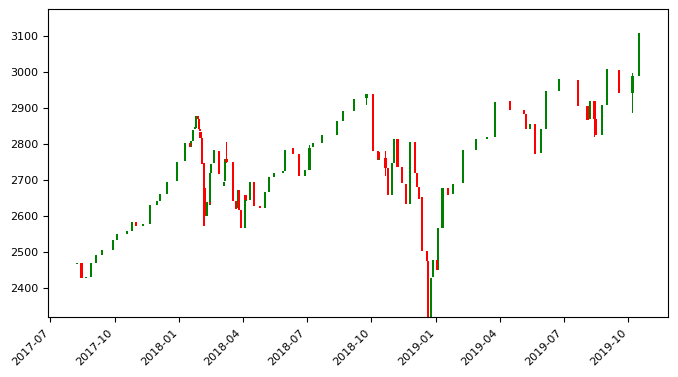

In [7]:
num_ticks = int(np.round(len(df1) / len(time_bars)))
tick_bars = SP500.create_tick_bars(num_ticks)
SP500.plot_bars(tick_bars, figsize = (8, 4), candle_width = 3)

## 3.4 Volume Bars

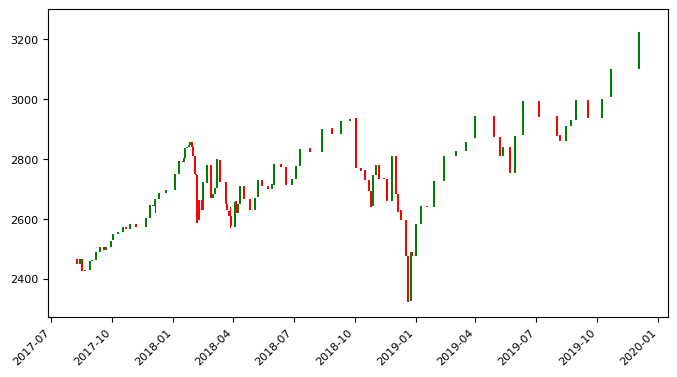

In [8]:
vol_per_bar = np.sum(df1['volume']) / len(time_bars)
volume_bars = SP500.create_volume_bars(vol_per_bar)
SP500.plot_bars(volume_bars, figsize = (8, 4), candle_width = 3)

## 3.5 Dollar Bars

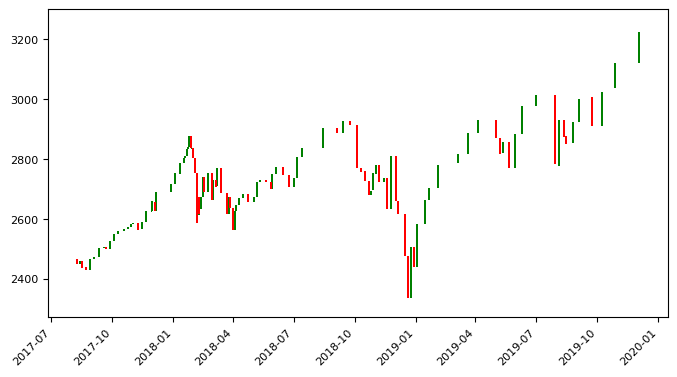

In [9]:
dol_per_bar = np.sum([df1['price'][i] * df1['volume'][i] for i in range(len(df1))]) / len(time_bars)
dollar_bars = SP500.create_dollar_bars(dol_per_bar)
SP500.plot_bars(dollar_bars, figsize = (8, 4), candle_width = 3)

## 3.6 Imbalance Bars

### 3.6.1 Tick Imbalance Bars

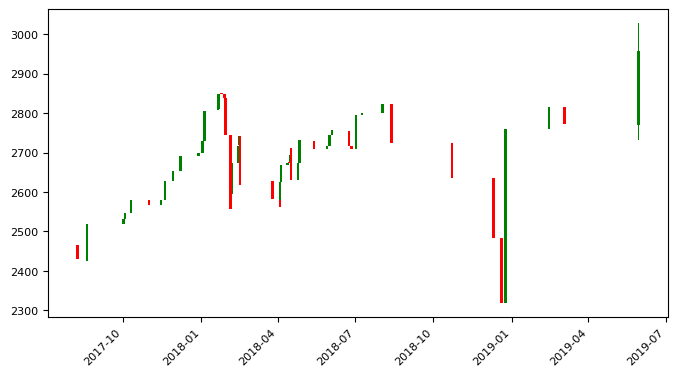

In [10]:
tib, t_c_i, t_thresholds = SP500.imbalance_bars(250, .5, "tick", 0.005)
SP500.plot_bars(tib, figsize = (8, 4), candle_width = 3)

### 3.6.2 Volume Imbalance Bars

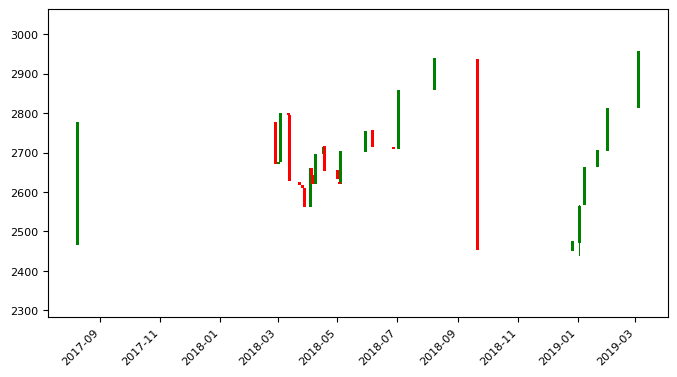

In [11]:
vib, v_c_i, v_thresholds = SP500.imbalance_bars(100, 4, "volume", 0.007)
SP500.plot_bars(vib, figsize = (8, 4), candle_width = 3)

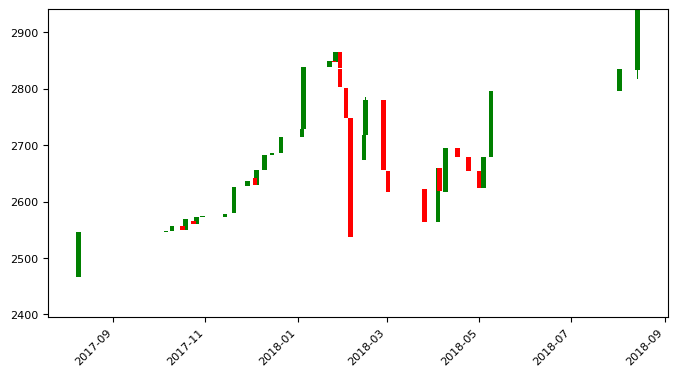

In [12]:
dib, d_c_i, d_thresholds = SP500.imbalance_bars(100, 9000, "dollar", 0.01)
SP500.plot_bars(dib, figsize = (8, 4), candle_width = 3)

## 3.7 CUSUM filtering

In [13]:
def CUSUM_Filter(bars, threshold):
    posS = 0
    negS = 0
    time_event = []
    price_event = []
    position = []
    rets = bars['Close'].pct_change().dropna()
    
    for i in range(len(rets)):
        posS = max(0, posS + rets[i])
        negS = min(0, negS + rets[i])
        
        if negS < -threshold:
            price_event.append(bars['Close'][i+1])
            time_event.append(rets.index[i])
            position.append(1)
            negS = 0
        
        elif posS > threshold:
            price_event.append(bars['Close'][i+1])
            time_event.append(rets.index[i])
            position.append(-1)
            posS = 0
    
    output = pd.DataFrame({'Date' : time_event,
                           'Close' : price_event,
                           'Tag' : position}, 
                          columns=['Date', 'Close', 'Tag'])
    output.index = output['Date']
    
    return output

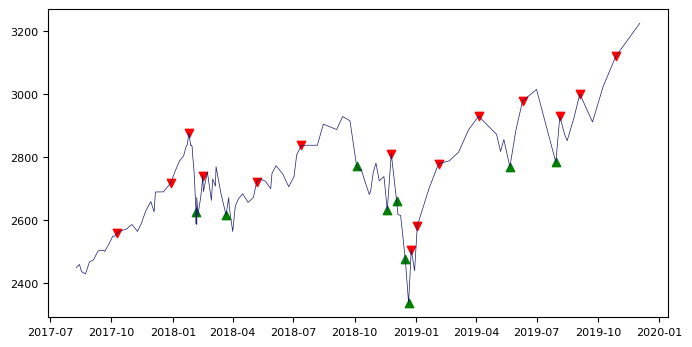

In [14]:
CF = CUSUM_Filter(dollar_bars, 0.05)
y1 = CF.loc[CF.Tag == 1]
y2 = CF.loc[CF.Tag == -1]
f = plt.figure(figsize=(8,4))
plt.plot(dollar_bars['Close'], c = 'midnightblue', linewidth=0.5)
plt.scatter(y1['Date'], y1['Close'], c = 'g', marker='^')
plt.scatter(y2['Date'], y2['Close'], c = 'r', marker='v')

# 4. Labeling and Meta Labeling

## 4.1 Fixed Horizon Labeling

In [15]:
def fixed_horizon_labeling(bars, horizon, threshold):
    T = len(bars)
    bars['Label'] = np.nan
    prices = bars['Close']
    labels = []
    
    for i in range(T - horizon):
        ret = prices[i + horizon] / prices[i] - 1
        if ret < - threshold:
            bars.loc[bars.index[i], 'Label'] = -1
        elif ret > threshold:
            bars.loc[bars.index[i], 'Label'] = 1
        else:
            bars.loc[bars.index[i], 'Label'] = 0
            
    
    output = bars[:T-horizon]
    
    return output

## 4.2 Triple Barrier Labeling

In [16]:
ttt = SP500.create_time_bars(1)

In [17]:
def get_daily_ret_vol(close, span0 = 100):
 
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    
    df0 = df0[df0>0]
    
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:]) 
    
    df0 = close.loc[df0.index] / close.loc[df0.values].values-1 # daily returns 
    
    df0 = df0.ewm(span = span0).std()
    
    return df0 

In [18]:
def triple_barrier_labeling(bars, horizon, up = 1, down = -1, span = 100):
    close_price = bars['Close']
    return_vol = get_daily_ret_vol(close_price, span).rename("ReturnVol", inplace= True)
    df = pd.concat([bars, return_vol], axis = 1).dropna()
    
    T = len(df)
    df['Return'] = 0
    df['Label'] = 0
    df['Upper_Th'] = 0
    df['Lower_Th'] = 0
    df['Vertical_Th'] = df['Date_start']
    df['Date_touched'] = df['Date_start']
    

    for i in range(T):
        upper_th = up * df['ReturnVol'][i] * df['Close'][i] + df['Close'][i]
        lower_th = down * df['ReturnVol'][i] * df['Close'][i] + df['Close'][i]
        df.loc[df.index[i], ['Upper_Th']] = upper_th
        df.loc[df.index[i], ['Lower_Th']] = lower_th
        df.loc[df.index[i], ['Vertical_Th']] = df['Date_start'][i] + datetime.timedelta(days = horizon)

        j = 0
        
        if i < T - horizon:
            hor_rest = horizon
        else:
            hor_rest = T - i
            
        while j < hor_rest:
            if df['Close'][i + j] >= upper_th:
                df.loc[df.index[i], ['Label']] = 1
                df.loc[df.index[i], ['Date_touched']] = df.index[i + j]
                df.loc[df.index[i], ['Return']] = df['Close'][i + j] / df['Close'][i] - 1
                break
            elif df['Close'][i + j] <= lower_th:
                df.loc[df.index[i], ['Label']] = -1
                df.loc[df.index[i], ['Date_touched']] = df.index[i + j]
                df.loc[df.index[i], ['Return']] = df['Close'][i + j] / df['Close'][i] - 1
                break
            else:
                df.loc[df.index[i], ['Date_touched']] = df.index[i + j]
                df.loc[df.index[i], ['Return']] = df['Close'][i + j] / df['Close'][i] - 1
            j = j + 1
     
    return df

In [19]:
tbl_bars = triple_barrier_labeling(ttt, 20, 2, -2)

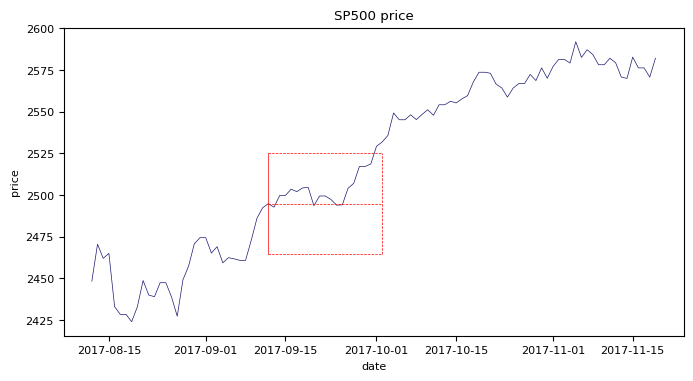

In [20]:
fig,ax = plt.subplots(figsize=(8, 4))
ax.set(title='SP500 price',xlabel='date', ylabel='price')
ax.plot(tbl_bars.Close[0: 100], c = 'midnightblue', linewidth=0.5)
start = tbl_bars.index[31]
end = tbl_bars.Vertical_Th[31]
upper_barrier = tbl_bars.Upper_Th[31]
lower_barrier = tbl_bars.Lower_Th[31]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--', linewidth=0.5);
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--', linewidth=0.5);
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--', linewidth=0.5);
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-', linewidth=0.5);
ax.plot([end, end], [lower_barrier, upper_barrier], 'r--', linewidth=0.5);

## 4.3 Meta Labeling
### Example for CusumFilter on SP500

In [21]:
meta_df = SP500.create_time_bars(1)
meta_cf = CUSUM_Filter(meta_df, 0.03)
tbl_bars = triple_barrier_labeling(meta_df, 10, 1, -1)

meta = pd.concat([meta_df, meta_cf['Tag'], tbl_bars['Label']], axis=1).fillna(0)

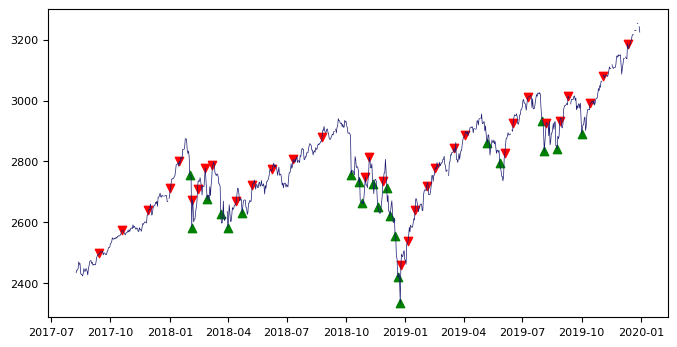

In [22]:
y1 = meta_cf.loc[meta_cf.Tag == 1]
y2 = meta_cf.loc[meta_cf.Tag == -1]
f = plt.figure(figsize=(8,4))
plt.plot(meta_df['Close'], c = 'midnightblue', linewidth=0.5)
plt.scatter(y1['Date'], y1['Close'], c = 'g', marker='^')
plt.scatter(y2['Date'], y2['Close'], c = 'r', marker='v')

In [23]:
split = int(0.7*len(meta))
train = meta[:split]
test= meta[split:]
X_train = train[['High', 'Low', 'Open', 'Close', 'Tag']]
y_train = train[['Label']]

X_test = test[['High', 'Low', 'Open', 'Close', 'Tag']]
y_test = test[['Label']]

clf2 = sklearn.ensemble.RandomForestClassifier(max_depth=5, random_state=0, n_jobs=-1)

clf2.fit(X_train, y_train)

y_predict = clf2.predict(X_test)
y_predict = np.ravel(y_predict)
y_true = np.ravel(y_test)

/var/folders/q0/ssgw9m190y10ltp1vb2rcthw0000gn/T/ipykernel_11827/2623382337.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf2.fit(X_train, y_train)


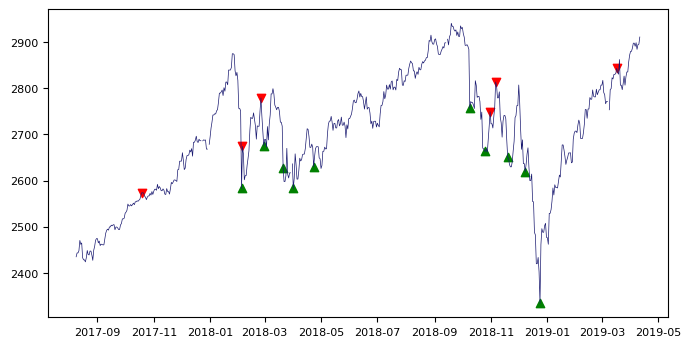

In [24]:
for i in range(len(train)):
    if train['Tag'][i] == train['Label'][i]:
        train.loc[train.index[i], ['RealTag']] = train['Label'][i]
    else:
        train.loc[train.index[i], ['RealTag']] = 0

y1 = train.loc[train.RealTag == 1]
y2 = train.loc[train.RealTag == -1]
f = plt.figure(figsize=(8,4))
        
plt.plot(meta_df['Close'][:split], c = 'midnightblue', linewidth=0.5)
plt.scatter(y1['Date_start'], y1['Close'], c = 'g', marker='^')
plt.scatter(y2['Date_start'], y2['Close'], c = 'r', marker='v')       

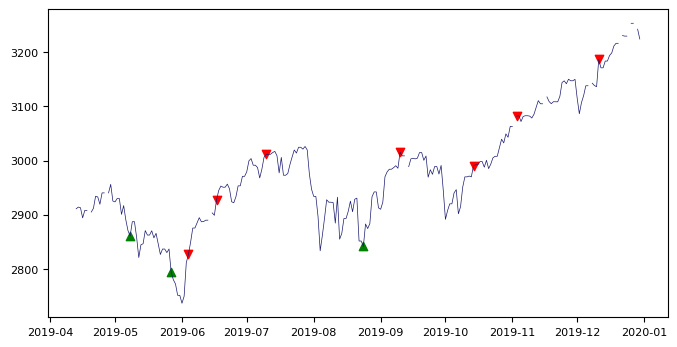

In [25]:
for i in range(len(test)):
    if test['Tag'][i] == y_predict[i]:
        test.loc[test.index[i], ['RealTag']] = y_predict[i]
    else:
        test.loc[test.index[i], ['RealTag']] = 0
        
y1 = test.loc[test.RealTag == 1]
y2 = test.loc[test.RealTag == -1]
f = plt.figure(figsize=(8,4))
        
plt.plot(meta_df['Close'][split+1:], c = 'midnightblue', linewidth=0.5)
plt.scatter(y1['Date_start'], y1['Close'], c = 'g', marker='^')
plt.scatter(y2['Date_start'], y2['Close'], c = 'r', marker='v')     

# 5. Fractional Differentiating

## 5.1 Gaussian Time Series

In [26]:
gaussian_ts = [np.random.standard_normal() for i in range(1000)]
res = sm.tsa.stattools.adfuller(gaussian_ts)
print("ADF Statistics = \"{}\" and P-Value = {}".format(res[0], res[1]))

ADF Statistics = "-32.60057533567387" and P-Value = 0.0


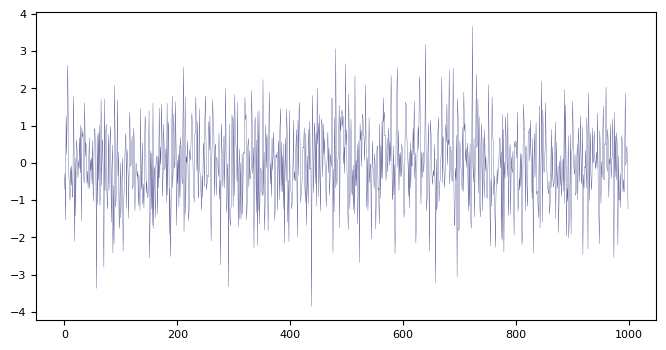

In [27]:
f = plt.figure(figsize=(8,4))
plt.plot(gaussian_ts, c = 'midnightblue', linewidth=0.2)

In [28]:
cum_gauss = []
val = 0
for i in range(len(gaussian_ts)):
    val = val + gaussian_ts[i]
    cum_gauss.append(val)
    
cum_res = sm.tsa.stattools.adfuller(cum_gauss)
print("ADF Statistics = \"{}\" and P-Value = {}".format(cum_res[0], cum_res[1]))
dif_cum_gauss = [cum_gauss[i] - cum_gauss[i-1] for i in range(1, len(cum_gauss))]
dif_cum_res = sm.tsa.stattools.adfuller(dif_cum_gauss)
print("Order of integration 1: ADF Statistics = \"{}\" and P-Value = {}".format(dif_cum_res[0], dif_cum_res[1]))
print("Order of integration is 1")

dif2_cum_gauss = [dif_cum_gauss[i] - dif_cum_gauss[i-1] for i in range(1, len(dif_cum_gauss))]
dif2_cum_res = sm.tsa.stattools.adfuller(dif2_cum_gauss)
print("Order of integration 2: ADF Statistics = \"{}\" and P-Value = {}".format(dif2_cum_res[0], dif2_cum_res[1]))

ADF Statistics = "-1.7597601750165093" and P-Value = 0.4006145972723545
Order of integration 1: ADF Statistics = "-32.58367009347842" and P-Value = 0.0
Order of integration is 1
Order of integration 2: ADF Statistics = "-11.21924582091361" and P-Value = 2.0329015302698867e-20


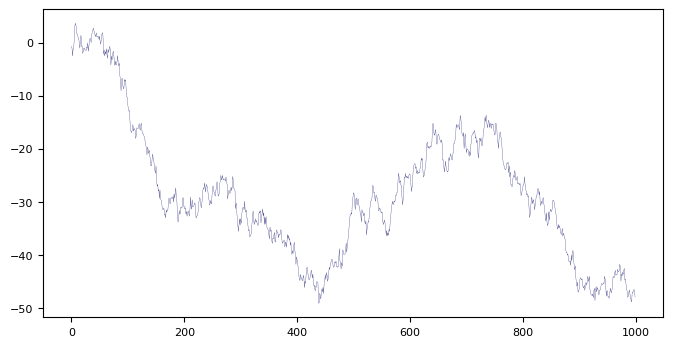

In [29]:
f = plt.figure(figsize=(8,4))
plt.plot(cum_gauss, c = 'midnightblue', linewidth=0.2)

## 5.2 Fractional Differentiating

In [30]:
def get_frac_weights(bins, d):
    
    w = [1]
        
    for i in range(1, len(bins)):
        w.append(-w[-1] * (d - i + 1) / i)
    
    return w


def frac_diff_expand(bins, d, threshold = 1):
    
    prices = bins['Close'].fillna(method="bfill")
    bins['AdjClose'] = np.nan
    
    weights = get_frac_weights(bins, d)
    abs_sum_w = np.sum(np.absolute(weights))
    
    for i in range(len(prices) - 1, -1, -1):
        
        memory_loss = np.sum(np.absolute(weights[i:])) / abs_sum_w
        
        if memory_loss < threshold:
            adj_price = np.dot(prices[:i], weights[:i][::-1])
            bins.loc[bins.index[i], 'AdjClose'] = adj_price
        
        else:
            break
            
    return bins


def frac_diff_fixed(bins, d, threshold = 0):
    
    prices = bins['Close'].fillna(method="bfill")
    bins['AdjClose'] = np.nan
    
    weights = get_frac_weights(bins, d)
    
    l = 0
    for i in range(len(weights)):
        if abs(weights[i]) <= threshold:
            weights[i] = 0
        else:
            l = i
    
    for i in range(len(prices) - 1, l, -1):
                
        adj_price = np.dot(prices[i - l - 1:i], weights[:l + 1][::-1])
        bins.loc[bins.index[i], 'AdjClose'] = adj_price
        
        
    return bins


def find_min_d(bins, method, threshold, tol = 1e-10):
    
    ADF = []
    mini_d = []
    D = np.linspace(0, 1, 11)
    for d in D:
        
        if method == 'Expanding':
            data = frac_diff_expand(bins, d, threshold)
        elif method == 'Fixed':
            data = frac_diff_fixed(bins, d, threshold)
        elif method == 'Naive':
            data = frac_diff_expand(bins, d, 1)
        else:
            raise TypeError("Choose from: 'Expanding', 'Fixed', 'Naive'")
            
        adf = sm.tsa.adfuller(data['AdjClose'].dropna())
        ADF.append(adf[0])
        
        if adf[1] < tol:
            mini_d.append(d)
    
    return mini_d[0], D, ADF

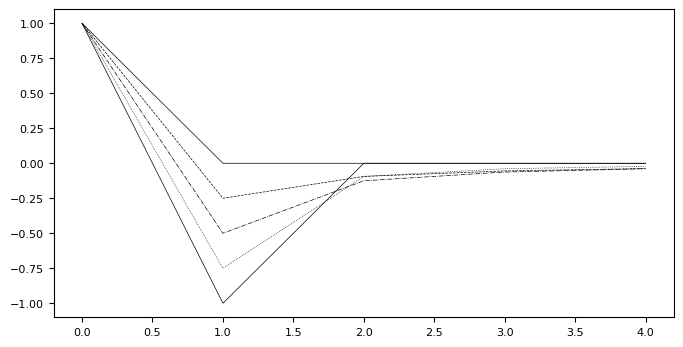

In [32]:
data = SP500.create_time_bars(1)[:5]

f = plt.figure(figsize=(8,4))
plt.plot(get_frac_weights(data, 0), '-', linewidth=0.5, c = 'black')
plt.plot(get_frac_weights(data, 0.25), '--', linewidth=0.5, c = 'black')
plt.plot(get_frac_weights(data, 0.5), '-.', linewidth=0.5, c = 'black')
plt.plot(get_frac_weights(data, 0.75), ':', linewidth=0.5, c = 'black')
plt.plot(get_frac_weights(data, 1), '-', linewidth=0.5, c = 'black')

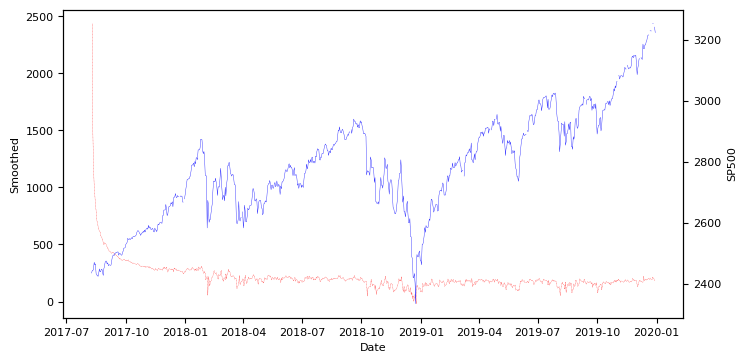

In [33]:
simple = SP500.create_time_bars(1)

fig, ax1 = plt.subplots(figsize=(8, 4))

ax2 = ax1.twinx()
ax1.plot(frac_diff_expand(simple, 0.4, 1)['AdjClose'], '--', linewidth=0.2, c = 'r')
ax2.plot(simple['Close'], '-', linewidth=0.25, c = 'b')

ax1.set_xlabel('Date')
ax1.set_ylabel('Smoothed', color='black')
ax2.set_ylabel('SP500', color='black')

plt.show()

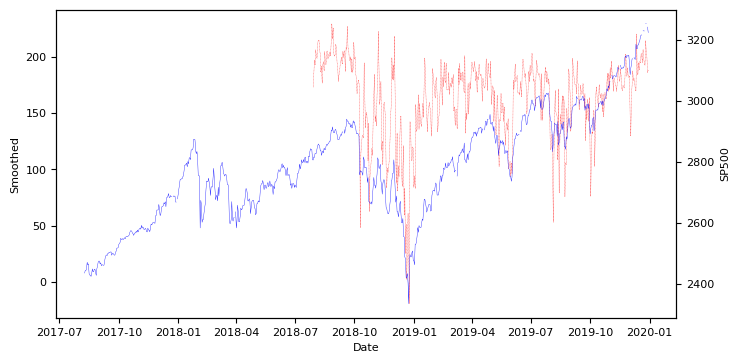

In [34]:
expand = SP500.create_time_bars(1)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.plot(frac_diff_expand(expand, 0.4, 0.01)['AdjClose'], '--', linewidth=0.2, c = 'r')
ax2.plot(expand['Close'], '-', linewidth=0.25, c = 'b')

ax1.set_xlabel('Date')
ax1.set_ylabel('Smoothed', color='black')
ax2.set_ylabel('SP500', color='black')

plt.show()

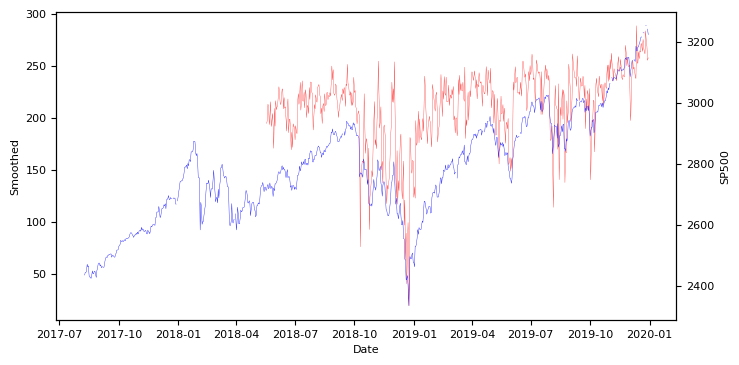

In [35]:
fixed = SP500.create_time_bars(1)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.plot(frac_diff_fixed(fixed, 0.4, 0.0001)['AdjClose'], '-', linewidth=0.2, c = 'r')
ax2.plot(fixed['Close'], '-', linewidth=0.25, c = 'b')

ax1.set_xlabel('Date')
ax1.set_ylabel('Smoothed', color='black')
ax2.set_ylabel('SP500', color='black')

plt.show()

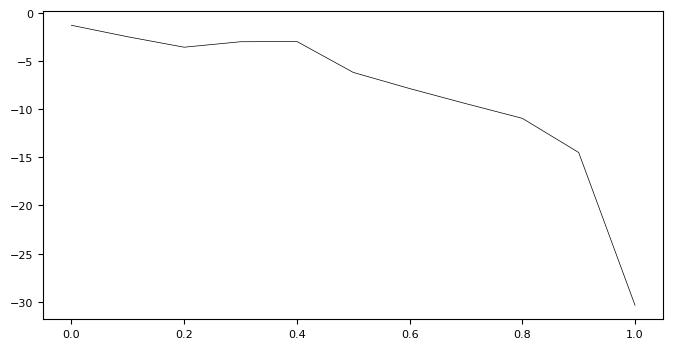

In [36]:
fixed = SP500.create_time_bars(1)
d, D, Adf = find_min_d(fixed, 'Fixed', 0.0001)

f = plt.figure(figsize=(8,4))
plt.plot(D, Adf, c = 'black', linewidth = 0.5)